# Develop a model to predict an individuals' credit score, given a feature set

#### Use the provided bank loan data to develop a model that can predict an individuals credit score, and then interpret the results to find the variables that are most predictive of the score.

This is a supervised, regression machine learning problem: given a set of data(x) with targets(y) (in this case the credit score) included, we want to train a model that can learn to map the features (also known as the explanatory variables) to the target.

- Supervised problem: we are given both the features and the target
- Regression problem: the target is a continous variable (credit score is a number between 0-800)

## Machine Learning Workflow
### Although the exact implementation details can vary, the general structure of a machine learning project stays relatively constant:

- Data cleaning and formatting
- Exploratory data analysis
- Feature engineering and selection
- Establish a baseline and compare several machine learning models on a performance metric
- Perform hyperparameter tuning on the best model to optimize it for the problem
- Evaluate the best model on the testing set
- Interpret the model results to the extent possible
- Draw conclusions and write a well-documented report

#### This is not a linear workflow, as in sequence is not always maintained in the pipeline. 
#### A step can be visited more than once based on evaluation further down the pipeline. It is an iterative process

In [1]:
##### # Imports

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
from random import randint

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

## Cleaning Data and Formatting

### Load Data and Examine

In [2]:
raw_df = pd.read_csv('credit_train.csv') #read training data

In [3]:
raw_df.head() #Take a look at the data

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
4,d4062e70-befa-4995-8643-a0de73938182,81536ad9-5ccf-4eb8-befb-47a4d608658e,Fully Paid,176220.0,Short Term,NaN,NaN,5 years,Rent,Debt Consolidation,20639.70,6.1,NaN,15.0,0.0,253460.0,427174.0,0.0,0.0


#### Count of data in each Column

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 19 columns):
Loan ID                         100000 non-null object
Customer ID                     100000 non-null object
Loan Status                     100000 non-null object
Current Loan Amount             100000 non-null float64
Term                            100000 non-null object
Credit Score                    80846 non-null float64
Annual Income                   80846 non-null float64
Years in current job            95778 non-null object
Home Ownership                  100000 non-null object
Purpose                         100000 non-null object
Monthly Debt                    100000 non-null float64
Years of Credit History         100000 non-null float64
Months since last delinquent    46859 non-null float64
Number of Open Accounts         100000 non-null float64
Number of Credit Problems       100000 non-null float64
Current Credit Balance          100000 non-null float64
Maxi

In [5]:
## Drop Loan ID and Customer ID as they are for identification purpose only
raw_df.drop(labels=['Loan ID', 'Customer ID'], axis=1, inplace=True)

### Need to Figure out percentage of missing data in each column

#### Following is a function that calculates the number of missing values and the percentage of the total values that are missing for each column. As with many tasks in data science, I did not write this function myself, but rather found it online in a [Stack Overflow Forum](https://stackoverflow.com/a/39734251)

In [6]:
# # Missing Values

# Function to calculate missing values by column
def missing_values_table(df):
    
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
 missing_values_table(raw_df)

Your selected dataframe has 17 columns.
There are 17 columns that have missing values.


,Missing Values,% of Total Values
Months since last delinquent,53655,53.4
Credit Score,19668,19.6
Annual Income,19668,19.6
Years in current job,4736,4.7
Bankruptcies,718,0.7
Tax Liens,524,0.5
Maximum Open Credit,516,0.5
Current Credit Balance,514,0.5
Number of Credit Problems,514,0.5
Number of Open Accounts,514,0.5


### It can be seen that Months since last delinquent has missing values > 50% 
#### Should be dropped
### Also the last 10 columns have same number of missing data

In [8]:
raw_df.drop(columns = 'Months since last delinquent', axis=1, inplace=True)

In [9]:
raw_df.shape

(100514, 16)

In [10]:
raw_df[raw_df['Monthly Debt'].isnull() == True]

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
### Last 514 rows are all NaN so drop them
raw_df.drop(raw_df.tail(514).index, inplace=True) # drop last 514 rows

In [12]:
## Check Missing values now
missing_values_table(raw_df)

Your selected dataframe has 16 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,19154,19.2
Annual Income,19154,19.2
Years in current job,4222,4.2
Bankruptcies,204,0.2
Tax Liens,10,0.0
Maximum Open Credit,2,0.0


In [13]:
# As the number of missing values is so low in the 'Maximum Open Credit' I will drop them.

for i in raw_df['Maximum Open Credit'][raw_df['Maximum Open Credit'].isnull() == True].index:
    raw_df.drop(labels=i, inplace=True)
missing_values_table(raw_df)

Your selected dataframe has 16 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,19153,19.2
Annual Income,19153,19.2
Years in current job,4222,4.2
Bankruptcies,204,0.2
Tax Liens,10,0.0


In [14]:
# As the number of missing values is so low in the 'Tax Liens' I will drop them.

for i in raw_df['Tax Liens'][raw_df['Tax Liens'].isnull() == True].index:
    raw_df.drop(labels=i, inplace=True)
missing_values_table(raw_df)

Your selected dataframe has 16 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,19149,19.2
Annual Income,19149,19.2
Years in current job,4222,4.2
Bankruptcies,194,0.2


In [15]:
# As the number of missing values is so low in the 'Bankruptcies' I will drop them.

for i in raw_df['Bankruptcies'][raw_df['Bankruptcies'].isnull() == True].index:
    raw_df.drop(labels=i, inplace=True)
missing_values_table(raw_df)

Your selected dataframe has 16 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Credit Score,19111,19.2
Annual Income,19111,19.2
Years in current job,4222,4.2


In [16]:
raw_df.shape

(99794, 16)

### Take a closer look at Credit Score

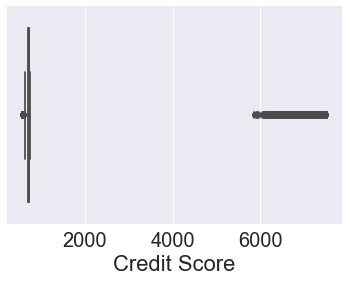

In [17]:
sns.boxplot(raw_df['Credit Score'])

#### It seems as if some of the scores are scaled up by 10

In [18]:
print(raw_df['Credit Score'].max())
print(raw_df['Credit Score'].min())
raw_df[raw_df['Credit Score'] > 800].shape

7510.0
585.0


(4540, 16)

In [19]:
### Scale down scores above 800
raw_df['Credit Score'] = raw_df['Credit Score'].apply(lambda val: (val /10) if val>800 else val)

In [20]:
print(raw_df['Credit Score'].max())
print(raw_df['Credit Score'].min())

751.0
585.0


In [21]:
# Now I will use the 'mean' technique to fill the NaN values.

raw_df['Credit Score'].fillna(raw_df['Credit Score'].mean(), inplace=True)
raw_df['Annual Income'].fillna(raw_df['Annual Income'].mean(), inplace=True)
missing_values_table(raw_df)

# The feature 'Years in current job' won't fill because it has categorical values.

Your selected dataframe has 16 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Years in current job,4222,4.2


### Take a closer look at years in current job

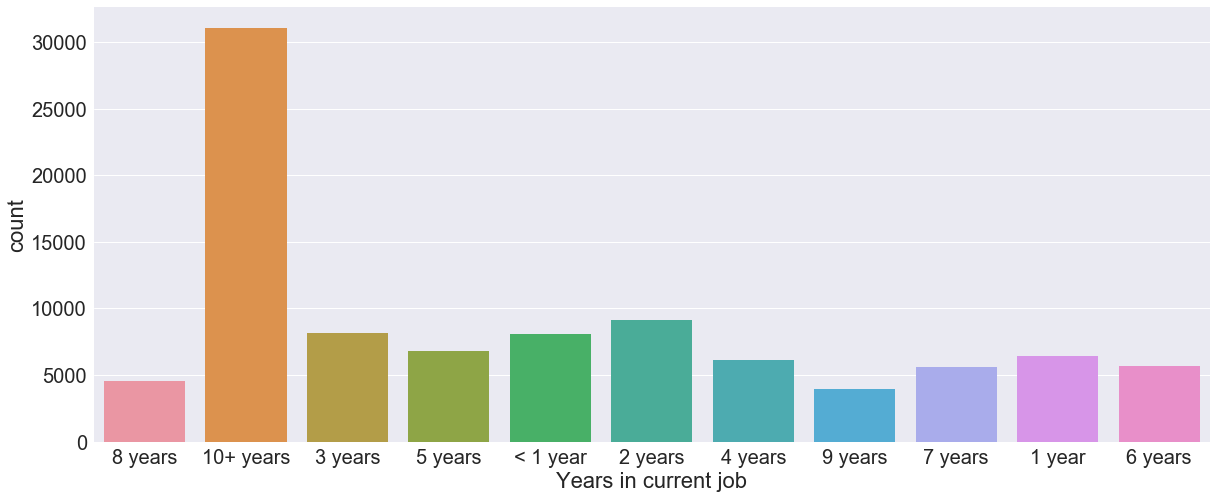

In [22]:
plt.figure(figsize=(20,8))
sns.countplot(raw_df['Years in current job'])

In [23]:
# Take the different categories in array
indexes = np.array(['8 years', '10+ years', '3 years', '5 years', '< 1 year',
           '2 years', '4 years', '9 years', '7 years', '1 year', '6 years'])

In [24]:
# randomly insert categories in the missing values

for i in raw_df['Years in current job'][raw_df['Years in current job'].isnull() == True].index:
    raw_df['Years in current job'][i] = indexes[randint(0, indexes.size -1)]
    
missing_values_table(raw_df)

Your selected dataframe has 16 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


#### The dataframe has zero missing values now !

## Exploratory Data Analysis

### Single variable plots

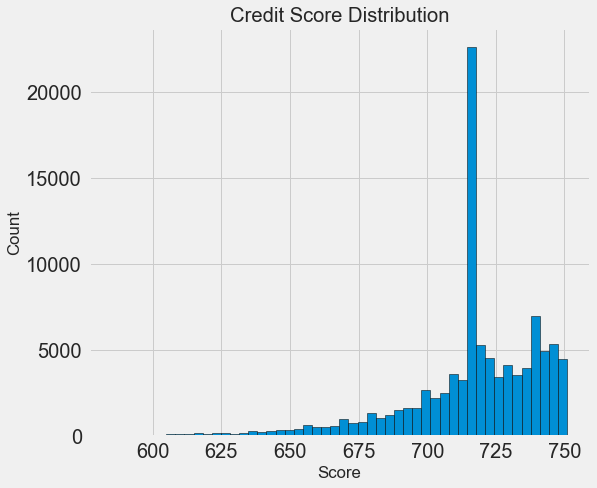

In [25]:
figsize(8, 7)

# Histogram of the Credit Score
plt.style.use('fivethirtyeight')
plt.hist(raw_df['Credit Score'], bins = 50, edgecolor = 'k');
plt.xlabel('Score'); plt.ylabel('Count'); 
plt.title('Credit Score Distribution');

#### Seems like a suspicously large percentage of people with credit score around 720, have to look into this later

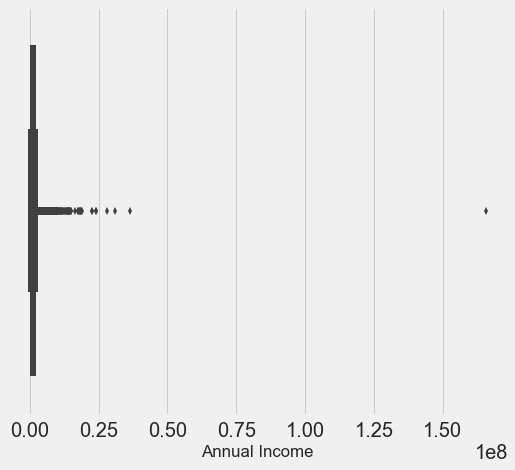

In [26]:
sns.boxplot(raw_df['Annual Income'])

#### Seems like outliers

In [27]:
raw_df[raw_df['Annual Income'] > 1e+08]
## This is a outlier as Loan Status is charged off, maybe a mistyping in the annual income

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
85662,Charged Off,176132.0,Short Term,725.0,165557393.0,10+ years,Home Mortgage,Debt Consolidation,15176.06,16.0,11.0,0.0,312778.0,669438.0,0.0,0.0


In [28]:
raw_df.drop(index=85662,inplace=True)

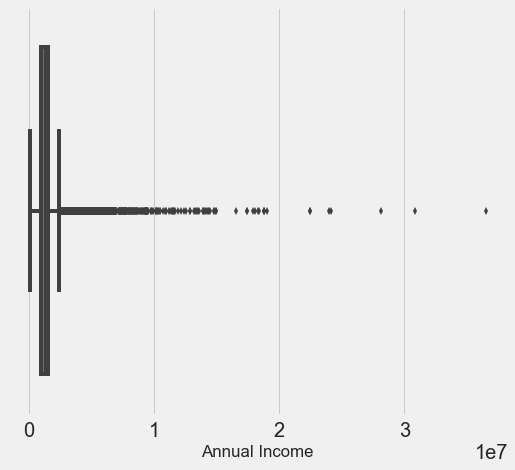

In [29]:
sns.boxplot(raw_df['Annual Income'])

In [30]:
raw_df['Credit Score'].mean()

716.2785834533995

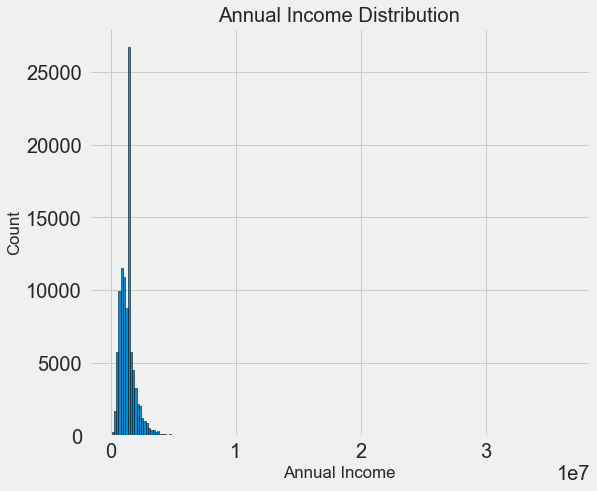

In [31]:
figsize(8, 7)

# Histogram of the Credit Score
plt.style.use('fivethirtyeight')
plt.hist(raw_df['Annual Income'], bins = 200, edgecolor = 'k');
plt.xlabel('Annual Income'); plt.ylabel('Count'); 
plt.title('Annual Income Distribution');

#### Distribution is still very skewed 

In [32]:
raw_df[raw_df['Annual Income'] > 1e+07]
# For now keep them like this, it can be observed that most of it is for the Purpose of Debt Consolidation

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
10721,Charged Off,757460.0,Long Term,739.0,30838995.0,< 1 year,Home Mortgage,Debt Consolidation,50113.45,14.7,15.0,0.0,499035.0,1532696.0,0.0,0.0
11522,Fully Paid,334356.0,Short Term,743.0,14438100.0,10+ years,Home Mortgage,Home Improvements,43795.57,17.7,10.0,0.0,3387529.0,5140740.0,0.0,0.0
11830,Fully Paid,784014.0,Short Term,706.0,12574770.0,10+ years,Rent,major_purchase,31646.40,16.9,16.0,0.0,69825.0,594440.0,0.0,0.0
12617,Fully Paid,463210.0,Short Term,724.0,14287050.0,10+ years,Home Mortgage,Debt Consolidation,43456.42,22.5,12.0,0.0,1234050.0,7403682.0,0.0,0.0
13643,Fully Paid,99999999.0,Long Term,617.0,14118007.0,10+ years,Home Mortgage,Debt Consolidation,63531.06,22.5,18.0,0.0,1224702.0,2017180.0,0.0,0.0
16028,Charged Off,521510.0,Short Term,653.0,11259780.0,4 years,Own Home,Other,66526.60,23.3,9.0,0.0,1092614.0,3243922.0,0.0,0.0
17561,Fully Paid,215644.0,Short Term,741.0,17400903.0,1 year,Rent,Debt Consolidation,24796.33,13.9,27.0,0.0,236569.0,399894.0,0.0,0.0
17803,Fully Paid,787952.0,Short Term,746.0,10499058.0,10+ years,Home Mortgage,other,78043.07,26.0,12.0,0.0,719169.0,1826132.0,0.0,0.0
20696,Fully Paid,99999999.0,Short Term,735.0,18743937.0,10+ years,Home Mortgage,Debt Consolidation,28584.55,25.0,17.0,0.0,501733.0,1115048.0,0.0,0.0
21598,Charged Off,753214.0,Short Term,745.0,24161540.0,5 years,Own Home,Debt Consolidation,15503.81,28.1,22.0,0.0,183635.0,1214972.0,0.0,0.0


In [33]:
### Check if Current Loan amount = 99999999 causes weird credit scores
raw_df[raw_df['Current Loan Amount'] > 0.2e+08]['Credit Score'].describe()


count    11457.000000
mean       725.756568
std         24.756044
min        587.000000
25%        717.000000
50%        734.000000
75%        743.000000
max        751.000000
Name: Credit Score, dtype: float64

## Examining relationships between Categorical features


Looking for Relationships
In order to look at the effect of categorical variables on the score, we can make a density plot colored by the value of the categorical variable. Density plots also show the distribution of a single variable and can be thought of as a smoothed histogram. If we color the density curves by a categorical variable, this will shows us how the distribution changes based on the class.
 [Taken Reference from](https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb)

In [34]:
# Create a list of Purposes with more than 100 measurements to avoid clutter
types = raw_df
types = types['Purpose'].value_counts()
types = list(types[types.values > 100].index)

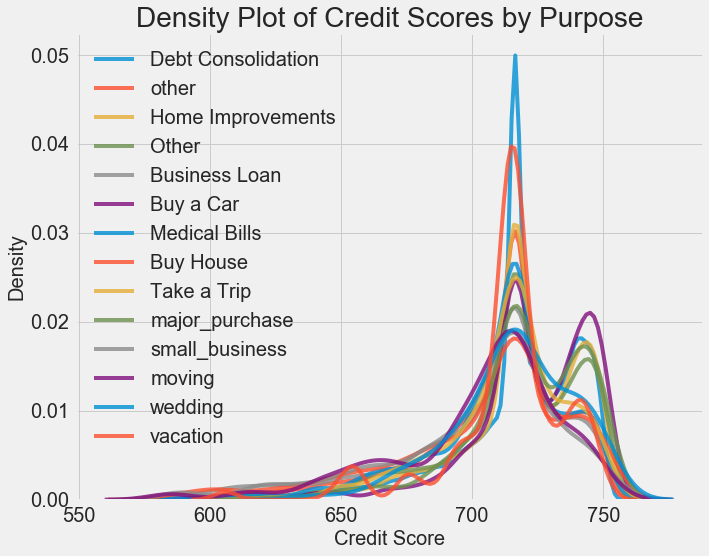

In [35]:
# Plot of distribution of Scores for each Purpose
figsize(10, 8)

# Plot each Purpose
for b_type in types:
    # Select the Purpose type
    subset = raw_df[raw_df['Purpose'] == b_type]
    
    # Density plot of scores
    sns.kdeplot(subset['Credit Score'],
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Credit Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Credit Scores by Purpose', size = 28);

### The type of Purpose doesn't have significant impact on distribution

In [36]:
# Create a list of Home OwnerShip with more than 100 measurements to avoid clutter
types = raw_df
types = types['Home Ownership'].value_counts()
types = list(types[types.values > 100].index)

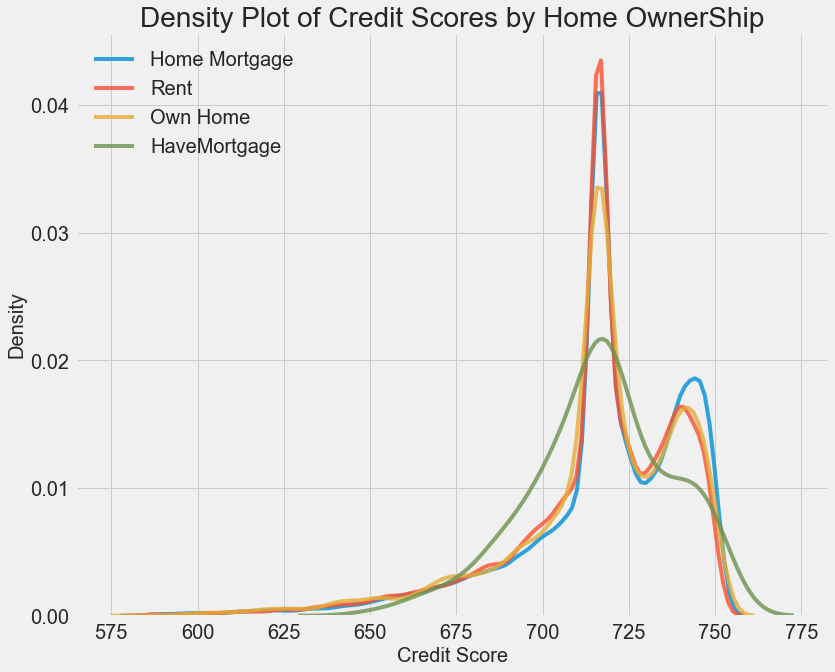

In [37]:
# Plot of distribution of Scores for each Home Ownership
figsize(12, 10)

# Plot each Purpose
for b_type in types:
    # Select the HomeOwnership type
    subset = raw_df[raw_df['Home Ownership'] == b_type]
    
    # Density plot of scores
    sns.kdeplot(subset['Credit Score'],
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Credit Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Credit Scores by Home OwnerShip', size = 28);

### The type of Home Ownership has slight impact on distribution

In [38]:
# Create a list of Term with more than 100 measurements to avoid clutter
types = raw_df
types = types['Term'].value_counts()
types = list(types[types.values > 100].index)

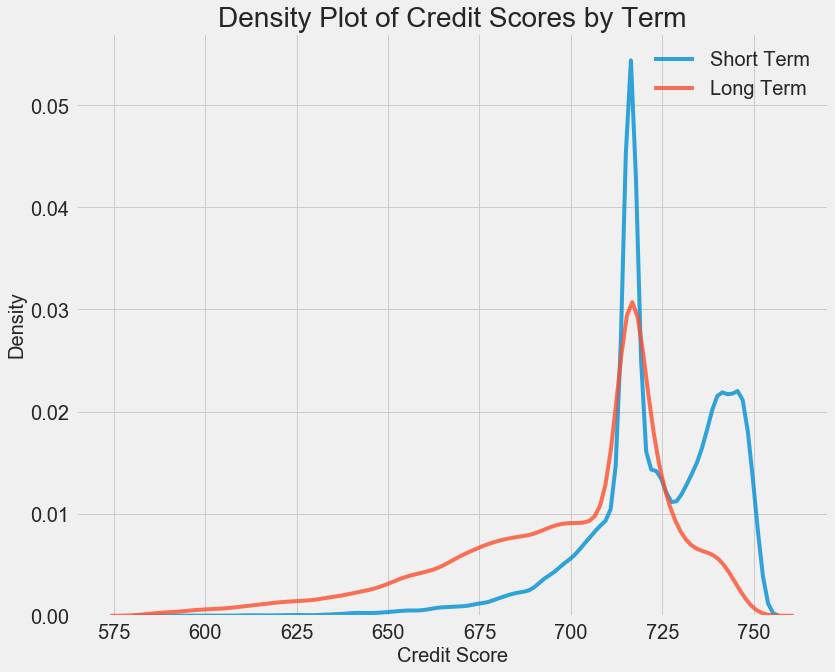

In [39]:
# Plot of distribution of Scores for each Term
figsize(12, 10)

# Plot each Term
for b_type in types:
    # Select the Term type
    subset = raw_df[raw_df['Term'] == b_type]
    
    # Density plot of scores
    sns.kdeplot(subset['Credit Score'],
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Credit Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Credit Scores by Term', size = 28);

In [40]:
# Create a list of Years in job with more than 100 measurements to avoid clutter
types = raw_df
types = types['Years in current job'].value_counts()
types = list(types[types.values > 100].index)

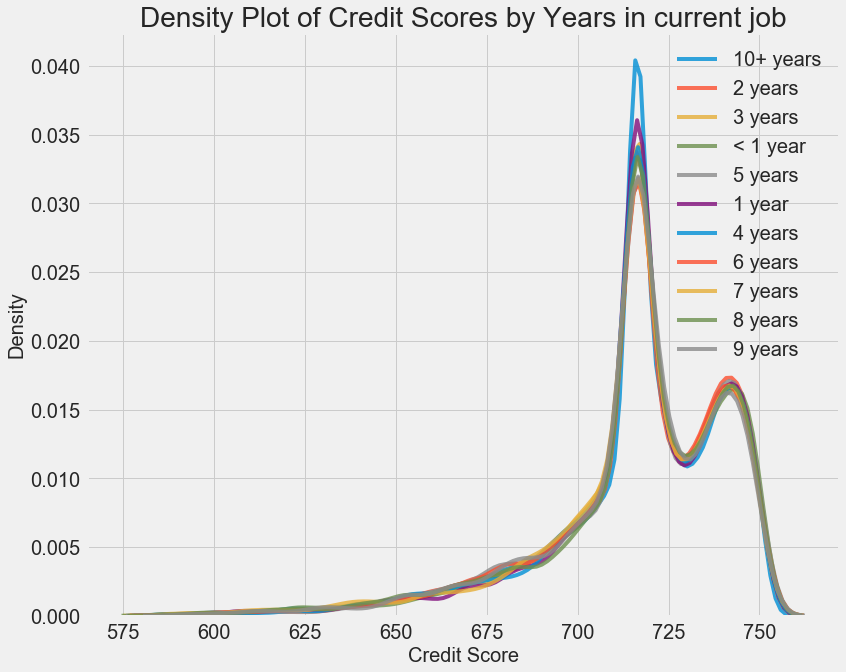

In [41]:
# Plot of distribution of Scores for each category
figsize(12, 10)

# Plot each category
for b_type in types:
    # Select the category type
    subset = raw_df[raw_df['Years in current job'] == b_type]
    
    # Density plot of scores
    sns.kdeplot(subset['Credit Score'],
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Credit Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Credit Scores by Years in current job', size = 28);

### Doesn't have any impact on distribution, would be okay to not include it 

## Correlations between Features and Target ¶
#### In order to quantify correlations between the features (variables) and the target, we can calculate the Pearson correlation coefficient. This is a measure of the strength and direction of a linear relationship between two variables: a value of -1 means the two variables are perfectly negatively linearly correlated and a value of +1 means the two variables are perfectly positively linearly correlated. The figure below shows different values of the correlation coeffient and how they appear graphically.

![title](img/correlation_examples.png)

In [42]:
# Find all correlations and sort 
correlations_data = raw_df.corr()['Credit Score'].sort_values()

# Print the Correlations
print(correlations_data)

Monthly Debt                -0.082134
Number of Credit Problems   -0.042880
Bankruptcies                -0.031185
Number of Open Accounts     -0.026942
Tax Liens                   -0.018942
Current Credit Balance      -0.014514
Annual Income               -0.006748
Maximum Open Credit          0.012821
Years of Credit History      0.069624
Current Loan Amount          0.133095
Credit Score                 1.000000
Name: Credit Score, dtype: float64


To account for possible non-linear relationships, we can take square root and natural log transformations of the features and then calculate the correlation coefficients with the score. To try and capture any possible relationships between the borough or building type (remember these are categorical variables) and the score we will have to one-hot encode these columns.

In the following code, we take log and square root transformations of the numerical variables, one-hot encode the two selected categorical variables (building type and borough), calculate the correlations between all of the features and the score, and display the top 15 most positive and top 15 most negative correlations. This is a lot, but with pandas, it is straightforward to do each step!


In [43]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99793 entries, 0 to 99999
Data columns (total 16 columns):
Loan Status                  99793 non-null object
Current Loan Amount          99793 non-null float64
Term                         99793 non-null object
Credit Score                 99793 non-null float64
Annual Income                99793 non-null float64
Years in current job         99793 non-null object
Home Ownership               99793 non-null object
Purpose                      99793 non-null object
Monthly Debt                 99793 non-null float64
Years of Credit History      99793 non-null float64
Number of Open Accounts      99793 non-null float64
Number of Credit Problems    99793 non-null float64
Current Credit Balance       99793 non-null float64
Maximum Open Credit          99793 non-null float64
Bankruptcies                 99793 non-null float64
Tax Liens                    99793 non-null float64
dtypes: float64(11), object(5)
memory usage: 12.9+ MB


## Create columns with square root and log of Numeric columns
### Normalising

In [44]:

# Select the numeric columns
numeric_subset = raw_df.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Credit Score column
    if col == 'Credit Score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = raw_df[['Loan Status', 'Term', 'Years in current job', 'Home Ownership', 'Purpose']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()['Credit Score'].dropna().sort_values()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


In [45]:
# Display most negative correlations
correlations.head(15)

Term_Long Term                   -0.422064
Loan Status_Charged Off          -0.095569
sqrt_Monthly Debt                -0.084519
Monthly Debt                     -0.082134
Purpose_other                    -0.080450
log_Monthly Debt                 -0.077137
Purpose_Business Loan            -0.060427
sqrt_Number of Credit Problems   -0.044925
Number of Credit Problems        -0.042880
Purpose_Buy House                -0.039528
log_Number of Credit Problems    -0.033955
Home Ownership_Rent              -0.032851
Bankruptcies                     -0.031185
Purpose_small_business           -0.030853
sqrt_Bankruptcies                -0.030837
Name: Credit Score, dtype: float64

In [46]:
# Display most positive correlations
correlations.tail(15)

Maximum Open Credit             0.012821
Purpose_Buy a Car               0.027429
Home Ownership_Home Mortgage    0.038008
Years of Credit History         0.069624
sqrt_Years of Credit History    0.073225
Purpose_Debt Consolidation      0.074748
log_Years of Credit History     0.075904
log_Current Loan Amount         0.079206
sqrt_Maximum Open Credit        0.080066
Loan Status_Fully Paid          0.095569
log_Maximum Open Credit         0.108519
sqrt_Current Loan Amount        0.124911
Current Loan Amount             0.133095
Term_Short Term                 0.422064
Credit Score                    1.000000
Name: Credit Score, dtype: float64

### It is seen that Current Loan amount,Term has strong correlation, lets plot scatter plot of to see its effect

In [76]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99793 entries, 0 to 99999
Data columns (total 67 columns):
Current Loan Amount               0 non-null float64
Credit Score                      0 non-null float64
Annual Income                     0 non-null float64
Monthly Debt                      0 non-null float64
Years of Credit History           0 non-null float64
Number of Open Accounts           0 non-null float64
Number of Credit Problems         0 non-null float64
Current Credit Balance            0 non-null float64
Maximum Open Credit               0 non-null float64
Bankruptcies                      0 non-null float64
Tax Liens                         0 non-null float64
sqrt_Current Loan Amount          0 non-null float64
log_Current Loan Amount           0 non-null float64
sqrt_Annual Income                0 non-null float64
log_Annual Income                 0 non-null float64
sqrt_Monthly Debt                 0 non-null float64
log_Monthly Debt                  0 non-nul

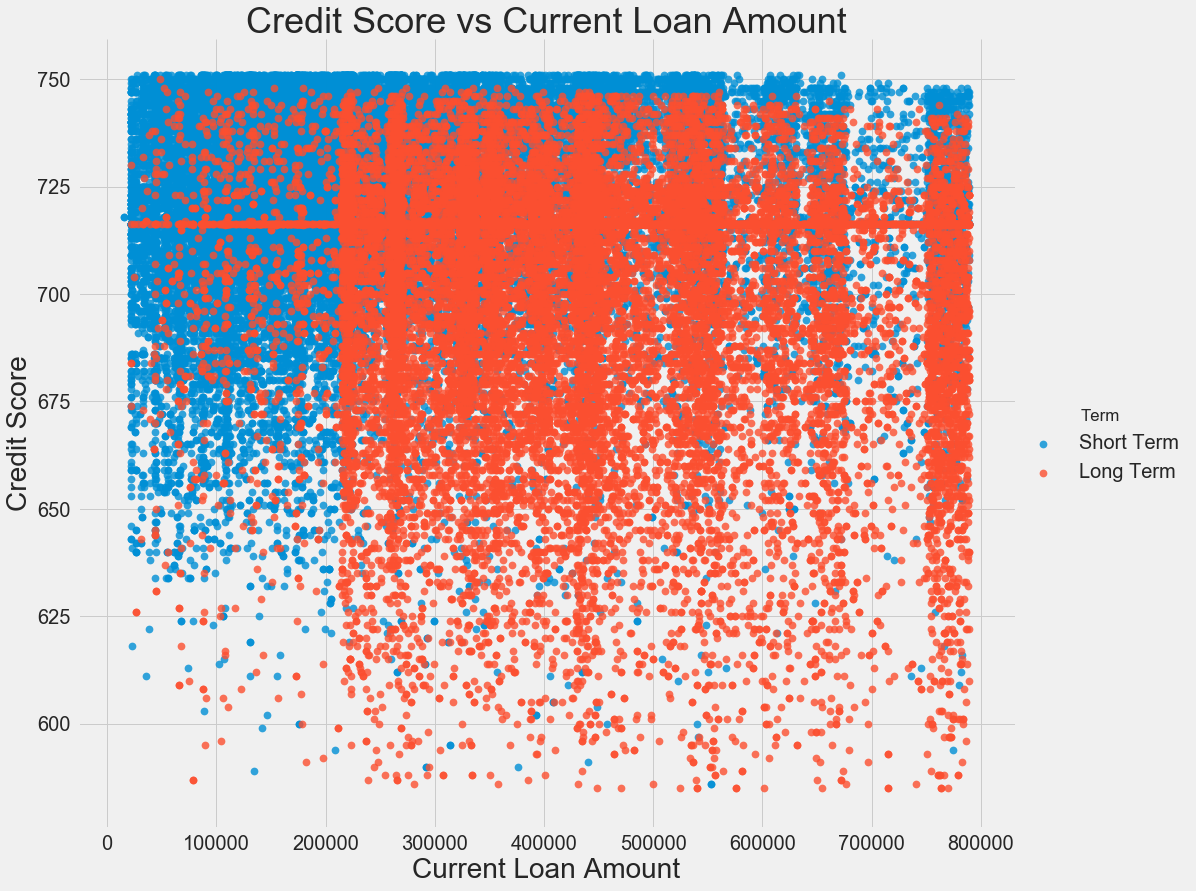

In [80]:
figsize(12, 10)

# Extract the Term types

features = raw_df[raw_df['Current Loan Amount'] < 1e07]
# Create a list of Term with more than 100 measurements to avoid clutter
types = raw_df
types = types['Term'].value_counts()
types = list(types[types.values > 200].index)
features = features[features['Term'].isin(types)]


# Use seaborn to plot a scatterplot of Score vs Log Source EUI
sns.lmplot('Current Loan Amount', 'Credit Score', 
          hue = 'Term', data = features,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          size = 12, aspect = 1.2);

# Plot labeling
plt.xlabel("Current Loan Amount", size = 28)
plt.ylabel('Credit Score', size = 28)
plt.title('Credit Score vs Current Loan Amount', size = 36);

## Feature Selection and Feature Engineering

- Feature Engineering: The process of taking raw data and extracting or creating new features that allow a machine learning model to learn a mapping beween these features and the target. This might mean taking transformations of variables, such as we did with the log and square root, or one-hot encoding categorical variables so they can be used in a model. Generally, I think of feature engineering as adding additional features derived from the raw data.
- Feature Selection: The process of choosing the most relevant features in your data. "Most relevant" can depend on many factors, but it might be something as simple as the highest correlation with the target, or the features with the most variance. In feature selection, we remove features that do not help our model learn the relationship between features and the target. This can help the model generalize better to new data and results in a more interpretable model. Generally, I think of feature selection as subtracting features so we are left with only those that are most important.

Feature engineering and selection are iterative processes that will usually require several attempts to get right. Often we will use the results of modeling, such as the feature importances from a random forest, to go back and redo feature selection, or we might later discover relationships that necessitate creating new variables. Moreover, these processes usually incorporate a mixture of domain knowledge and statistical qualitites of the data.

In [81]:
## Remove multi-linearity 
### Features which are highly collinear due to some underlying similarity
### Hence keeping them is redundant 

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Energy Star Score
    y = x['Credit Score']
    x = x.drop(columns = ['Credit Score'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # Add the score back in to the data
    x['Credit Score'] = y
               
    return x

In [82]:
feat = remove_collinear_features(features, 0.6)

Bankruptcies | Number of Credit Problems | 0.75


In [83]:
## Features with collinear ones removed
feat.head()

,Loan Status,Current Loan Amount,Term,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Tax Liens,Credit Score
0,Fully Paid,445412.0,Short Term,1.167493e+06,8 years,Home Mortgage,Home Improvements,5214.74,17.2,6.0,1.0,228190.0,416746.0,0.0,709.000000
1,Fully Paid,262328.0,Short Term,1.378339e+06,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,35.0,0.0,229976.0,850784.0,0.0,716.278671
3,Fully Paid,347666.0,Long Term,8.069490e+05,3 years,Own Home,Debt Consolidation,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,721.000000
4,Fully Paid,176220.0,Short Term,1.378339e+06,5 years,Rent,Debt Consolidation,20639.70,6.1,15.0,0.0,253460.0,427174.0,0.0,716.278671
5,Charged Off,206602.0,Short Term,8.968570e+05,10+ years,Home Mortgage,Debt Consolidation,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,729.000000


In [84]:
feat = feat.drop(columns='Term')

In [85]:
feat.head()

,Loan Status,Current Loan Amount,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Tax Liens,Credit Score
0,Fully Paid,445412.0,1.167493e+06,8 years,Home Mortgage,Home Improvements,5214.74,17.2,6.0,1.0,228190.0,416746.0,0.0,709.000000
1,Fully Paid,262328.0,1.378339e+06,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,35.0,0.0,229976.0,850784.0,0.0,716.278671
3,Fully Paid,347666.0,8.069490e+05,3 years,Own Home,Debt Consolidation,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,721.000000
4,Fully Paid,176220.0,1.378339e+06,5 years,Rent,Debt Consolidation,20639.70,6.1,15.0,0.0,253460.0,427174.0,0.0,716.278671
5,Charged Off,206602.0,8.968570e+05,10+ years,Home Mortgage,Debt Consolidation,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,729.000000


## Split Into Training and Testing Sets

In [86]:
temp = feat

In [55]:
X = temp.drop(columns='Credit Score')
y = temp['Credit Score']

In [56]:
# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

In [57]:
# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(69855, 42)
(29938, 42)
(69855,)
(29938,)


## Set Baseline
To compare against model
What is error of random guess

In [58]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [59]:
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 716.28
Baseline Performance on the test set: MAE = 17.6026


In [60]:
# Save the no scores, training, and testing data
X.to_csv('data/training_features.csv', index = False)
X_test.to_csv('data/testing_features.csv', index = False)
y.to_csv('data/training_labels.csv', index = False)
y_test.to_csv('data/testing_labels.csv', index = False)